In [1]:
# import the imagenette dataset
from datasets import load_dataset

imagenette = load_dataset(
    'frgfm/imagenette',
    '320px',
    split='validation',
    revision="4d512db"
)
# show dataset info
imagenette

c:\Users\imran\anaconda3\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for frgfm/imagenette contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/frgfm/imagenette
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

In [2]:
# check labels in the dataset
set(imagenette['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [3]:
# labels names 
labels = imagenette.info.features['label'].names
labels

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [4]:
# generate sentences
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a tench',
 'a photo of a English springer',
 'a photo of a cassette player',
 'a photo of a chain saw',
 'a photo of a church',
 'a photo of a French horn',
 'a photo of a garbage truck',
 'a photo of a gas pump',
 'a photo of a golf ball',
 'a photo of a parachute']

In [5]:
# initialization
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

c:\Users\imran\anaconda3\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\imran\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

c:\Users\imran\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
import torch

# if you have CUDA set it to the active device like this
device = "cuda" if torch.cuda.is_available() else "cpu"
# move the model to the device
model.to(device)

device

'cuda'

In [7]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320,  1149,   634, 49407],
       device='cuda:0')

In [8]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [9]:

label_emb.min(), label_emb.max()

(-1.9079257, 6.1716285)

In [10]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.87605506, 0.89617455)

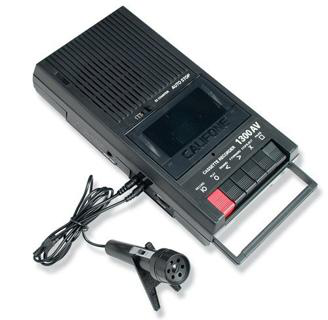

In [11]:
imagenette[0]['image']

In [23]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 

from torchvision import transforms
from torch.utils.data import Dataset
import pandas as pd
from skimage import io
import os

df_train = 'C:/dataset/audio_post_train.csv' # chnage 
df_val  = 'C:/dataset/face_post_test.csv'
class BabyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations.iloc[2748:]	# remove for full data	
        #self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path =  self.annotations.iloc[idx, 0]
        image = io.imread(img_path)
        
        if self.transform:
          image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32)

        # image = image.detach().clone()
        # image = image.type(torch.float)
        y_label = self.annotations.iloc[idx, 1]
        y_label = np.array(y_label)
        y_label = y_label.astype('int')
        y_label = y_label.tolist()
        return image, y_label
    

# transform 
trans = transforms.Compose([
  #transforms.ToTensor(),
  transforms.ToPILImage(),
  transforms.Resize((160, 160)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.6414, 0.8491, 0.6575], std=[0.3448, 0.1205, 0.3073]) 
])

#DataLoader 
train_set = BabyDataset(csv_file = df_train,  transform= trans)
print ('train data', len(train_set))

train_dataloader = DataLoader(dataset=train_set, batch_size= 16, shuffle=True)


train data 2684


In [24]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features [0].shape}")
print(f"Labels batch shape: {train_labels [1].shape}")

train_features, train_labels = next(iter(train_dataloader))
sample_image = train_features [0].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)


C:\Users\imran\AppData\Local\Temp\ipykernel_19252\390484206.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Feature batch shape: torch.Size([3, 160, 160])
Labels batch shape: torch.Size([])
Input shape torch.Size([1, 3, 160, 160])


TypeError: CLIPModel.forward() got an unexpected keyword argument 'timestep'

In [25]:

image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt'
)['pixel_values'].to(device)
image.shape

ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-2.1648521423339844, 1.2522822618484497] which cannot be converted to uint8.

In [13]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [14]:
img_emb = img_emb.detach().cpu().numpy()

In [15]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [16]:
# get index of highest score
pred = np.argmax(scores)
pred

2

In [20]:
# find text label with highest score
labels[pred]

'cassette player'

In [18]:
from tqdm.auto import tqdm

preds = []
batch_size = 32

for i in tqdm(range(0, len(imagenette), batch_size)):
    i_end = min(i + batch_size, len(imagenette))
    images = processor(
        text=None,
        images=imagenette[i:i_end]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/123 [00:00<?, ?it/s]

In [19]:
true_preds = []
for i, label in enumerate(imagenette['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

sum(true_preds) / len(true_preds)

0.9870063694267516

In [29]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\imran\appdata\local\temp\pip-req-build-syuc458_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 53.4/53.4 kB 696.0 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369579 sha256=d74d0d5fccfa1ef2bba05912da0c2cfc1e43699b489fea802c05b145d7e5d4b8
  Stored in directory: C:\Users\imran\AppData\Local\Temp\pip-ephem-wheel-cache-9_y15a8j\wheels\da\2b\4c\d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth-0.2.5
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\imran\AppData\Local\Temp\pip-req-build-syuc458_'


In [37]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

img_path = r'C:\dataset\processed_p_salekin\video_subjects\1_I4C1B1F1E1V#P0_sub016_vid03_seg_01-3-of-4\face\Iframe001.png'

image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = clip.tokenize([ "NO PAIN", "PAIN"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.363 0.637]]
